In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import conntility


# Load spikes

In [3]:
import bluepysnap as bp
path_to_simulation = '../sscxSimulation/'
s = bp.Simulation(path_to_simulation+'simulation_config.json') # Loads simulation object
population_name = s.reports['lfp_report'].population_names[0]

r  = s.reports['lfp_report'][population_name]

In [4]:
regions = ['S1FL','S1DZ','S1DZO','S1HL','S1Sh','S1Tr','S1ULp'] # Subregions of SSCx

types = np.sort(list(s.circuit.nodes.property_values('mtype'))) # Cell types

In [5]:


index = 0

path_to_spikes = '../sscxSimulation/pkls/'

# Iterates through all regions and cell types and concatenates spike reports loaded from pickle files (produced by getSpikes.py)
for region in regions:
    for t in types:
        
        report = pd.read_pickle(path_to_spikes+'/spikes_'+region+'_'+t+'.pkl')
        
        if index == 0:
            spikeReports = report
        else:
            spikeReports = pd.concat((spikeReports,report))
        

# Load signals

In [6]:
   
Signals = {}

f = path_to_simulation+'/pkls/'

# Iterates through all regions and cell types and loads extarcellular signals from pickle files (produced by geteeg.py)
for region in regions:
    for t in types:
        Signals[region+'_'+t] = pd.read_pickle(f+'/eeg_'+region+'_'+t+'.pkl')


In [7]:
regions = ['S1FL','S1DZ','S1DZO','S1HL','S1Sh','S1Tr','S1ULp']

byRegion = {}

# Sums signals over all cell types for each region
for region in regions:
    
    byRegion[region] = 0
    
    for key in Signals.keys():
        if region in key:
            byRegion[region] += Signals[key]


In [8]:
signalTotal = 0

# Sums signal over regions and cell types
for key, value in Signals.items():
    signalTotal += value      


In [9]:
snapshots = np.array([3200,3250,3300,3350,3400,3500])
timeWindow = np.array([3250,4000])

# Plot signals

The following cell produces Figure 3C in the BlueRecording paper

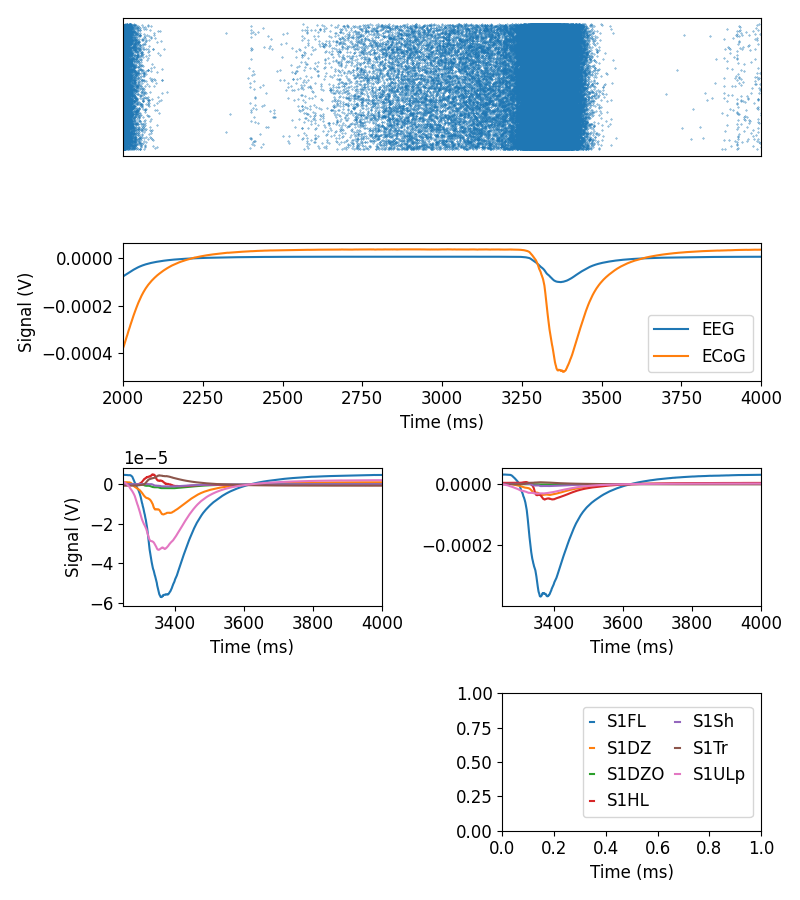

In [10]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,9))

gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 1])


ax1.scatter(spikeReports.index,spikeReports.values,s=.1)
ax1.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
ax1.set_xlim([2000,4000])

# Plots total EEG and ECoG Signals
ax2.plot(signalTotal['Forelimb_EEG_Reciprocity'])
ax2.plot(signalTotal['Forelimb_ECoG_Reciprocity'])
ax2.set_ylabel('Signal (V)')
ax2.set_xlabel('Time (ms)')

ax2.legend(['EEG','ECoG'])

ax2.set_xlim([2000,4000])


for region in regions:

    # Plots contribution to the EEG signal from each subregion
    ax3.plot(byRegion[region]['Forelimb_EEG_Reciprocity'])
    
    plt.xlabel('Time (ms)')
    ax3.set_ylabel('Signal (V)')
                 
    ax3.set_xlim([3250,4000])
    ax3.set_xlabel('Time (ms)')
                     
    
    

    # Plots contribution to the ECoG signal from each subregion             
    ax4.plot(byRegion[region]['Forelimb_ECoG_Reciprocity'])

    ax4.set_xlabel('Time (ms)')
                 
    ax4.set_xlim([3250,4000])

# This plots the legned for the previous panel in a new panel. 
for region in regions:
    ax5.plot(-.05,-.05)
ax5.set_xlim([0,1])
ax5.set_ylim([0,1])
ax5.legend(regions,ncol=2,loc='right',handlelength=0.25,columnspacing=0.6)
                 
    

plt.tight_layout()

plt.savefig('figures/eegByRegion.png',dpi=300)

# Samples cells from exemplary regions and gets scaling factors

In [11]:
circuit = s.circuit

In [12]:
nodes = circuit.nodes

In [13]:
# Loads a generator that produces the cell types for all cells in forelimb, hindlimb, and upper lip regions

nFl = nodes.get('S1FL',properties=['mtype'])
nHl = nodes.get('S1HL',properties=['mtype'])
nULp = nodes.get('S1ULp',properties=['mtype'])

In [14]:
# Loads node ids for Layer 5 TPC:A cells from each of the above regions

Fl = next(nFl)[1]
Fl = np.array(list(Fl[Fl['mtype']=='L5_TPC:A'].index))[:,1].astype(int)

Hl = next(nHl)[1]
Hl = np.array(list(Hl[Hl['mtype']=='L5_TPC:A'].index))[:,1].astype(int)

ULp = next(nULp)[1]
ULp = np.array(list(ULp[ULp['mtype']=='L5_TPC:A'].index))[:,1].astype(int)

In [15]:
import h5py

In [16]:
# Loads the weights file

coeffsFile = "../electrodeFile/coeffsEcog_EEG.h5"

coeffs = h5py.File(coeffsFile)

In [18]:
# Node ids from weights file
allNodeIds = coeffs['S1nonbarrel_neurons']['node_ids']

In [19]:
# Finds indices in the weights file of nodes in the selected regions

flIndex = np.where(np.isin(allNodeIds[:],Fl))[0]
hlIndex = np.where(np.isin(allNodeIds[:],Hl))[0]
ulpIndex = np.where(np.isin(allNodeIds[:],ULp))[0]


In [20]:
np.random.seed(1776)

# Samples nodes from the selected regions

flIndex = np.sort(np.random.choice(flIndex,1000,replace=False))
hlIndex = np.sort(np.random.choice(hlIndex,1000,replace=False))
ulpIndex = np.sort(np.random.choice(ulpIndex,1000,replace=False))

FLshort = allNodeIds[:][flIndex]
HLshort = allNodeIds[:][hlIndex]
ULPshort = allNodeIds[:][ulpIndex]


In [22]:
# Finds offsets for the compartment weights for the selected nodes

flOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex+1]]
hlOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][hlIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][hlIndex+1]]
ulpOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][ulpIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][ulpIndex+1]]


In [23]:
# Gets compartment weights for the selected nodes (shifted such that the minimum weight for each neuron is 0)

scaleFacFl = []
scaleFacHl = []
scaleFacULp = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,1]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,1]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,1]
    sulp -= np.min(sulp)

    scaleFacFl.append( sfl )
    scaleFacHl.append( shl )
    scaleFacULp.append( sulp )

scaleFacFlEcog = []
scaleFacHlEcog = []
scaleFacULpEcog = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,0]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,0]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,0]
    sulp -= np.min(sulp)

    scaleFacFlEcog.append( sfl )
    scaleFacHlEcog.append( shl )
    scaleFacULpEcog.append( sulp )



# Loads 3d positions

In [24]:
path_to_positions = "../data/getPositions/positions_all_new/"


In [25]:
# Loads positions for a subset of the selected nodes

allIds = [FLshort, HLshort, ULPshort]

allIds = [s for item in allIds for s in item]

allIds = np.array(allIds)

import os

i = 0

for subfolder in os.listdir(path_to_positions):
    for file in os.listdir(path_to_positions+subfolder):
        
        if i > 10:
            break
        
        positions = pd.read_pickle(path_to_positions+subfolder+'/'+file)
        
        columns = np.array(list(positions.columns))[:,0]
        
        indices = np.where(np.isin(allIds,columns))[0]
        
        if len(indices)==0:
            continue
        
        idsInFile = allIds[indices]

        positions = positions[idsInFile]
        
        if i == 0:
            allPositions = positions
        else:
            allPositions = pd.concat((allPositions,positions),axis=1)
            
        i += 1
        

In [26]:
ids = np.unique(np.array(list(allPositions.columns))[:,0])

In [27]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints for a single neuron
    '''

    
    secIds = np.array(list(position.columns))
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos

In [28]:
# Spatial positions of the electrodes

ecog = np.array([3996,-777,-308.95])
eeg = np.array([3996,-777,2423.97])
returnElectrode = np.array([2677,851,2947.32])
lfp = np.array([3996,-777,-1308.95])

In [29]:
import numpy
import pandas
import h5py
import os

import neurom
import conntility
import bluepysnap as bluepy

from scipy import interpolate
from matplotlib import pyplot as plt

fn_electrodes = "../electrodeFile/coeffsEcog_EEG.h5"
fn_sim = '../data/simulation/simulation_config.json'
neuron_pop_str = "S1nonbarrel_neurons"


class ElectrodeReader(object):
    def __init__(self, fn_electrodes, fn_sim, neuron_pop_str):
        self.sim = bluepy.Simulation(fn_sim)
        self.circ = self.sim.circuit
        self.elec_h5 = h5py.File(fn_electrodes, "r")
        self.pop = neuron_pop_str
        self.e_df = self._read_electrode_metadata()
        self.nrn_df = self._read_neuron_dataframe()
        rep_fn = os.path.join(self.sim.config["output"]["output_dir"],
                              self.sim.reports["compartment"].config["file_name"] + ".h5")
        self.rep = h5py.File(rep_fn, "r")

        
    def _read_electrode_metadata(self):
        grp = self.elec_h5["electrodes"]

        populations = list(self.elec_h5.keys())
        populations.pop(populations.index("electrodes"))
        assert self.pop in populations

        electrodes = [int(_k) for _k in grp.keys() if _k not in populations]
        props = ["layer", "position", "region", "type"]

        electrode_series = []
        for electrode_id in electrodes:
            e = pandas.Series(dict([(_prop, grp[str(electrode_id)][_prop][()])
                                     for _prop in props]))
            electrode_series.append(e)

        e_df = pandas.concat(electrode_series, axis=1, keys=electrodes).transpose()
        return e_df
    
    def _read_neuron_dataframe(self):
        props = ["mtype", "morphology", "layer", "region", "x", "y", "z", "flat_x", "flat_y"]
        nrn = conntility.circuit_models.neuron_groups.load_neurons(self.circ, props,
                                                           base_target=self.sim.config["node_set"],
                                                           node_population=self.pop)
        return nrn
    
    def morph_dir(self, morph_format="h5v1"):
        nodes = self.circ.config["networks"]["nodes"][0]
        return nodes["populations"][self.pop]["alternate_morphologies"][morph_format]
    
    def mapping_sec_ids(self, node_id):
        rep_grp = self.rep["report"][self.pop]["mapping"]
        j = numpy.nonzero(rep_grp["node_ids"][:] == node_id)[0][0]
        idx = rep_grp["index_pointers"][j:j+2]

        e_ids = rep_grp["element_ids"][idx[0]:idx[1]]
        return e_ids
    
    def electrode_weights(self, node_id):
        node_ids = self.elec_h5[self.pop]["node_ids"][:]
        assert node_id in node_ids
        i = numpy.nonzero(node_ids == node_id)[0][0]
        idx = self.elec_h5[self.pop]["offsets"][i:(i+2)]
        
        factors = self.elec_h5["electrodes"][self.pop]["scaling_factors"][idx[0]:idx[1]]

        factors -= factors.min(axis=0)
        
        
        e_ids = self.mapping_sec_ids(node_id)
        factor_df = pandas.DataFrame(factors, index=pandas.Index(e_ids.astype(int) - 1, name="sec_id"))
        return factor_df
    
    def morphology(self, node_id):
        morph_fn = os.path.join(
            self.morph_dir(),
            self.nrn_df.set_index("node_ids")["morphology"][node_id] + ".h5"
        )
        return neurom.load_morphology(morph_fn)
    
    def neuron(self, node_id, electrode_id):
        return ElectrodeHelper(self.electrode_weights(node_id)[electrode_id],
                               self.morphology(node_id))

    
class ElectrodeHelper(object):
    def __init__(self, weights, morphology):
        self.weights = weights
        self.morph = morphology
        
    @property
    def sec_types(self):
        data = [[_sec.id, int(_sec.type)] for _sec in self.morph.sections]
        sec_type = pandas.DataFrame(data, columns=["sec_id", "sec_type"]).set_index("sec_id")["sec_type"]
        sec_type[-1] = 1 # soma
        sec_type[numpy.max(sec_type.index) + 1] = 5 # invalid
        return sec_type
    
    def mean(self):
        return self.weights.mean()
    
    def means_for_types(self):
        sec_type = self.sec_types
        tmp_df = pandas.Series(self.weights.values, name="weights",
                              index=pandas.Index(sec_type[self.weights.index].values, name="sec_type"))
        return tmp_df.groupby("sec_type").mean()
    
    def hist_for_types(self, nbins=31):
        bins = numpy.linspace(self.weights.min(), self.weights.max() + 1E-12, nbins+1)
        sec_type = self.sec_types
        tmp_df = pandas.Series(self.weights.values, name="weights",
                              index=pandas.Index(sec_type[self.weights.index].values, name="sec_type"))
        def hist_series(w):
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            return pandas.Series(
                numpy.histogram(w, bins=bins)[0], name="count",
                index=pandas.Index(bin_centers, name="weight")
            )
        return tmp_df.groupby("sec_type").apply(hist_series).unstack("weight")
    
    def plot(self, ax=None):
        if ax is None:
            fig = plt.figure(figsize=(3, 7))
            ax = fig.gca()
        
        f_norm = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())
        morph = self.morph

        # Soma
        _c = f_norm[-1]
        #plt.plot(0, 0, marker='o', color=[1.0 - _c, _c, 0])

        for sec in morph.sections:
            if sec.id not in f_norm:
                continue
            l = numpy.linalg.norm(numpy.diff(sec.points, axis=0)[:, :3], axis=1)
            L = numpy.sum(l)
            midpoints = 0.5 * (numpy.hstack([0, numpy.cumsum(l[:-1])]) + numpy.cumsum(l))

            this_diff = f_norm[sec.id]
            if isinstance(this_diff, float):
                this_diff = numpy.array([this_diff])
            else:
                this_diff = this_diff.values

            x = numpy.linspace(0, L, len(this_diff) + 2)[1:-1]
            c = numpy.interp(midpoints, x, this_diff, left=this_diff[0],right=this_diff[-1])

            for p_fr, p_to, _c in zip(sec.points[:-1], sec.points[1:], c):
                ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]],
                        color=[1.0 - _c, _c, 0])

        ax.set_aspect("equal")
        ax.set_frame_on(False)
    
    
tst = ElectrodeReader(fn_electrodes, fn_sim, neuron_pop_str)

## Exemplary neurons in each region

In each region of the model, we find a neuron of the target m-type (L5_TPC:A) that is among the most central.
We use it as a representative example of how a neuron in that region would be affecting the signal

In [30]:
region_centers = tst.nrn_df.groupby("region")[["flat_x", "flat_y"]].mean().astype(int).reset_index()
display(region_centers)
morph_lookup = tst.nrn_df.set_index(["mtype", "region", "flat_x", "flat_y"])["node_ids"]

tgt_mtype = "L5_TPC:A"


picked_node_ids = {}
for _, row in region_centers.iterrows():
    morph_filtered = morph_lookup[tgt_mtype][row["region"]]
    D = morph_filtered.index.to_frame() - row[["flat_x", "flat_y"]]
    D = (D ** 2).sum(axis=1)
    cands = morph_filtered.loc[D.loc[D == D.min()].index]
    picked_node_ids[row["region"]] = numpy.random.choice(cands.values)
    
display(picked_node_ids)

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2173399/ipykernel_99412/1577147346.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_centers = tst.nrn_df.groupby("region")[["flat_x", "flat_y"]].mean().astype(int).reset_index()


,region,flat_x,flat_y
0,S1DZ,63,100
1,S1DZO,64,33
2,S1FL,33,90
3,S1HL,20,148
4,S1J,32,18
5,S1Sh,59,157
6,S1Tr,53,172
7,S1ULp,110,55


{'S1DZ': 4176600,
 'S1DZO': 3999761,
 'S1FL': 3970497,
 'S1HL': 3906473,
 'S1J': 4020679,
 'S1Sh': 3917512,
 'S1Tr': 4194667,
 'S1ULp': 3965306}

In [31]:
def histmean(histogram):    

    return np.sum(histogram.index*histogram.values) / histogram.sum()

The following cell produces Figure 4:

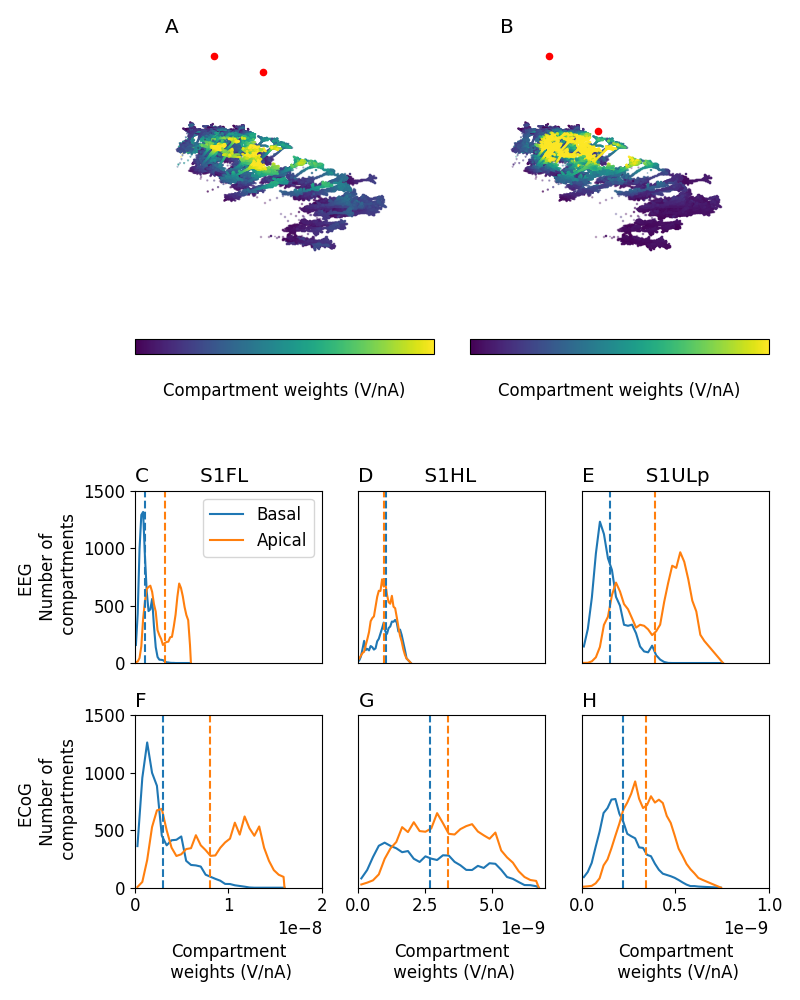

In [32]:
from matplotlib.gridspec import GridSpec


import types

plt.rcParams['axes.formatter.useoffset'] = False

fig = plt.figure(figsize=(8,10))

gs = GridSpec(4, 6, figure=fig)
ax1 = fig.add_subplot(gs[:-2, 0:3],projection='3d')
ax2 = fig.add_subplot(gs[:-2, 3:],projection='3d')
ax3 = fig.add_subplot(gs[-2, 0:2])
ax4 = fig.add_subplot(gs[-2, 2:4])
ax5 = fig.add_subplot(gs[-2, 4:])
ax6 = fig.add_subplot(gs[-1, 0:2])
ax7 = fig.add_subplot(gs[-1, 2:4])
ax8 = fig.add_subplot(gs[-1, 4:])

#####
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG
for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFl
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHl
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax1.scatter(p[0],p[1],p[2],marker=marker,c=scale,s=.5,vmin=0,vmax=5e-9)
    
ax1.view_init(elev=9., azim=-85)

# Plots locations of electrodes
ax1.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
ax1.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20) 

ax1.set_xlim((2801.1161576783625, 6260.576980695542))
ax1.set_ylim((-2284.337284947517, 1883.8635116069354))
ax1.set_zlim((-4332.110601382281, 914.4962633882312))

ax1.set_title('A',ha='left', x=-0)

ax1.axis('off')

cb = plt.colorbar(im,fraction=0.25,location='bottom')

cb.set_label(label='Compartment weights (V/nA)',labelpad=20)
cb.set_ticks([])
#####

#####
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for ECoG
plt.tight_layout()

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlEcog
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlEcog
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpEcog
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values

    im = ax2.scatter(p[0],p[1],p[2],marker=marker,c=scale,s=.5,vmin=0,vmax=15e-9)
    
ax2.view_init(elev=9., azim=-85)

ax2.scatter(ecog[0],ecog[1],ecog[2],c='r',s=20)

ax2.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

ax2.set_title('B',ha='left', x=-0)

ax2.set_xlim((2801.1161576783625, 6260.576980695542))
ax2.set_ylim((-2284.337284947517, 1883.8635116069354))
ax2.set_zlim((-4332.110601382281, 914.4962633882312))

cb = plt.colorbar(im,fraction=0.25,location='bottom')

cb.set_label(label='Compartment weights (V/nA)',labelpad=20)
cb.set_ticks([])

ax2.set_axis_off()

plt.tight_layout()
#####

pad = plt.rcParams["xtick.major.size"] + plt.rcParams["xtick.major.pad"]

def bottom_offset(self, bboxes, bboxes2):
    bottom = self.axes.bbox.ymin
    self.offsetText.set(va="top", ha="left") 
    oy = bottom - pad * self.figure.dpi / 72.0
    self.offsetText.set_position((1.05, oy))


####
# Creates histograms of compartment weights for each selected region

HFl_eeg = 0
HHl_eeg = 0
HUlp_eeg = 0 


HFl_ecog = 0
HHl_ecog = 0
HUlp_ecog = 0 

flIdx = 0
hlIdx = 0
ulpIdx = 0

for i in ids:

    if i in FLshort:

        if flIdx == 0:

            HFl_eeg += tst.neuron(i, 1).hist_for_types().transpose()
            
    
            HFl_ecog += tst.neuron(i, 0).hist_for_types().transpose()
            

        else:
            
            HFl_eeg += tst.neuron(i, 1).hist_for_types().transpose().values
    
            HFl_ecog += tst.neuron(i, 0).hist_for_types().transpose().values
        

        flIdx += 1
            

    if i in HLshort:

        if hlIdx == 0:
            
            HHl_eeg += tst.neuron(i, 1).hist_for_types().transpose()
    
            HHl_ecog += tst.neuron(i, 0).hist_for_types().transpose()

        else:
            HHl_eeg += tst.neuron(i, 1).hist_for_types().transpose().values
    
            HHl_ecog += tst.neuron(i, 0).hist_for_types().transpose().values


        hlIdx += 1
            

    if i in ULPshort:

        if ulpIdx == 0:

            HUlp_eeg += tst.neuron(i, 1).hist_for_types().transpose()
    
            HUlp_ecog += tst.neuron(i, 0).hist_for_types().transpose()

        else:

            HUlp_eeg += tst.neuron(i, 1).hist_for_types().transpose().values
    
            HUlp_ecog += tst.neuron(i, 0).hist_for_types().transpose().values


        ulpIdx += 1
########


########
# Plots histograms

basal = pd.concat((HFl_eeg[3], pd.Series(0,index=[HFl_eeg[3].index[-1]+1e-10])))
apical= pd.concat((HFl_eeg[4], pd.Series(0,index=[HFl_eeg[4].index[-1]+1e-10])))

ax3.plot(basal, label="Basal") # sec_id 3 is basal (that is canon)
ax3.plot(apical, label="Apical") # sec_id 4 is apical (that is canon)

ax3.plot([histmean(HFl_eeg[3]),histmean(HFl_eeg[3])],[0,1500],'--',c='C0')
ax3.plot([histmean(HFl_eeg[4]),histmean(HFl_eeg[4])],[0,1500],'--',c='C1')

ax3.set_title('C        S1FL',ha='left', x=-0)

ax3.set_ylabel('EEG \n Number of \n compartments')

ax3.set_ylim([0,1500])
ax3.set_xticks([])
ax3.set_xlim([0,2e-8])
ax3.legend()


plt.tight_layout()

ax6.plot(pd.concat((HFl_ecog[3], pd.Series(0,index=[HFl_ecog[3].index[-1]+1e-10]))), label="Basal") # sec_id 3 is basal (that is canon)
ax6.plot(pd.concat((HFl_ecog[4], pd.Series(0,index=[HFl_ecog[4].index[-1]+1e-10]))), label="Apical") # sec_id 4 is apical (that is canon)

ax6.set_title('F',ha='left', x=-0)

ax6.set_ylabel('ECoG \n Number of \n compartments')
ax6.set_xlabel('Compartment\n weights (V/nA)',labelpad=20)

ax6.plot([histmean(HFl_ecog[3]),histmean(HFl_ecog[3])],[0,1500],'--',c='C0')
ax6.plot([histmean(HFl_ecog[4]),histmean(HFl_ecog[4])],[0,1500],'--',c='C1')

ax6.set_ylim([0,1500])
ax6.set_xlim([0,2e-8])

plt.tight_layout()

ax4.plot(pd.concat((HHl_eeg[3], pd.Series(0,index=[HHl_eeg[3].index[-1]+1e-10]))), label="Basal") # sec_id 3 is basal (that is canon)
ax4.plot(pd.concat((HHl_eeg[4], pd.Series(0,index=[HHl_eeg[4].index[-1]+1e-10]))), label="Apical") # sec_id 4 is apical (that is canon)


ax4.plot([histmean(HHl_eeg[3]),histmean(HHl_eeg[3])],[0,1500],'--',c='C0')
ax4.plot([histmean(HHl_eeg[4]),histmean(HHl_eeg[4])],[0,1500],'--',c='C1')

ax4.set_title('D        S1HL',ha='left', x=-0)
ax4.set_yticks([])
ax4.set_xticks([])
ax4.set_ylim([0,1500])
ax4.set_xlim([0,7e-9])



plt.tight_layout()

ax7.plot(pd.concat((HHl_ecog[3], pd.Series(0,index=[HHl_ecog[3].index[-1]+1e-10]))), label="Basal") # sec_id 3 is basal (that is canon)
ax7.plot(pd.concat((HHl_ecog[4], pd.Series(0,index=[HHl_ecog[4].index[-1]+1e-10]))), label="Apical") # sec_id 4 is apical (that is canon)

ax7.plot([histmean(HHl_ecog[3]),histmean(HHl_ecog[3])],[0,1500],'--',c='C0')
ax7.plot([histmean(HHl_ecog[4]),histmean(HHl_ecog[4])],[0,1500],'--',c='C1')

ax7.set_xlabel('Compartment\n weights (V/nA)',labelpad=20)

ax7.set_title('G',ha='left', x=-0)
ax7.set_yticks([])
ax7.set_ylim([0,1500])
ax7.set_xlim([0,7e-9])

plt.tight_layout()

ax5.plot(pd.concat((HUlp_eeg[3], pd.Series(0,index=[HUlp_eeg[3].index[-1]+1e-10]))), label="Basal") # sec_id 3 is basal (that is canon)
ax5.plot(pd.concat((HUlp_eeg[4], pd.Series(0,index=[HUlp_eeg[4].index[-1]+1e-10]))), label="Apical") # sec_id 4 is apical (that is canon)

ax5.plot([histmean(HUlp_eeg[3]),histmean(HUlp_eeg[3])],[0,1500],'--',c='C0')
ax5.plot([histmean(HUlp_eeg[4]),histmean(HUlp_eeg[4])],[0,1500],'--',c='C1')

ax5.set_title('E        S1ULp',ha='left', x=-0)
ax5.set_yticks([])
ax5.set_xticks([])
ax5.set_ylim([0,1500])
ax5.set_xlim([0,1e-9])


plt.tight_layout()

ax8.plot(pd.concat((HUlp_ecog[3], pd.Series(0,index=[HUlp_ecog[3].index[-1]+1e-10]))), label="Basal") # sec_id 3 is basal (that is canon)
ax8.plot(pd.concat((HUlp_ecog[4], pd.Series(0,index=[HUlp_ecog[4].index[-1]+1e-10]))), label="Apical") # sec_id 4 is apical (that is canon)

ax8.plot([histmean(HUlp_ecog[3]),histmean(HUlp_ecog[3])],[0,1500],'--',c='C0')
ax8.plot([histmean(HUlp_ecog[4]),histmean(HUlp_ecog[4])],[0,1500],'--',c='C1')

ax8.set_xlabel('Compartment\n weights (V/nA)',labelpad=20)

ax8.set_title('H',ha='left', x=-0)
ax8.set_yticks([])
ax8.set_ylim([0,1500])
ax8.set_xlim([0,1e-9])

plt.tight_layout()

plt.savefig('figures/mechanism.png',dpi=600)


# Differences between methods

In [33]:
# Loads compartment weights for LFP for eaach selected region

scaleFacFlLfp = []
scaleFacHlLfp = []
scaleFacULpLfp = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,2]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,2]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,2]
    sulp -= np.min(sulp)

    scaleFacFlLfp.append( sfl )
    scaleFacHlLfp.append( shl )
    scaleFacULpLfp.append( sulp )

In [34]:
# Loads compartment weights calculted with dipole method, for ECoG

scaleFacFlDipoleEcog = []
scaleFacHlDipoleEcog = []
scaleFacULpDipoleEcog = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,3]
    sfl -= np.min(sfl[0])
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,3]
    shl -= np.min(shl[0])
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,3]
    sulp -= np.min(sulp[0])

    scaleFacFlDipoleEcog.append( sfl )
    scaleFacHlDipoleEcog.append( shl )
    scaleFacULpDipoleEcog.append( sulp )

In [35]:
# Loads compartment weights calculted with dipole method, for EEG

scaleFacFlDipole = []
scaleFacHlDipole = []
scaleFacULpDipole = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,4]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,4]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,4]
    sulp -= np.min(sulp)

    scaleFacFlDipole.append( sfl )
    scaleFacHlDipole.append( shl )
    scaleFacULpDipole.append( sulp )

In [36]:
# Loads compartment weights calculted with dipole method, for LFP

scaleFacFlDipoleLfp = []
scaleFacHlDipoleLfp = []
scaleFacULpDipoleLfp = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,5]
    sfl -= np.min(sfl)
    
    shl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][hlOffsets[0][i]:hlOffsets[1][i]][:,5]
    shl -= np.min(shl)
    
    sulp = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][ulpOffsets[0][i]:ulpOffsets[1][i]][:,5]
    sulp -= np.min(sulp)

    scaleFacFlDipoleLfp.append( sfl )
    scaleFacHlDipoleLfp.append( shl )
    scaleFacULpDipoleLfp.append( sulp )

The following cell produces Figure 5:

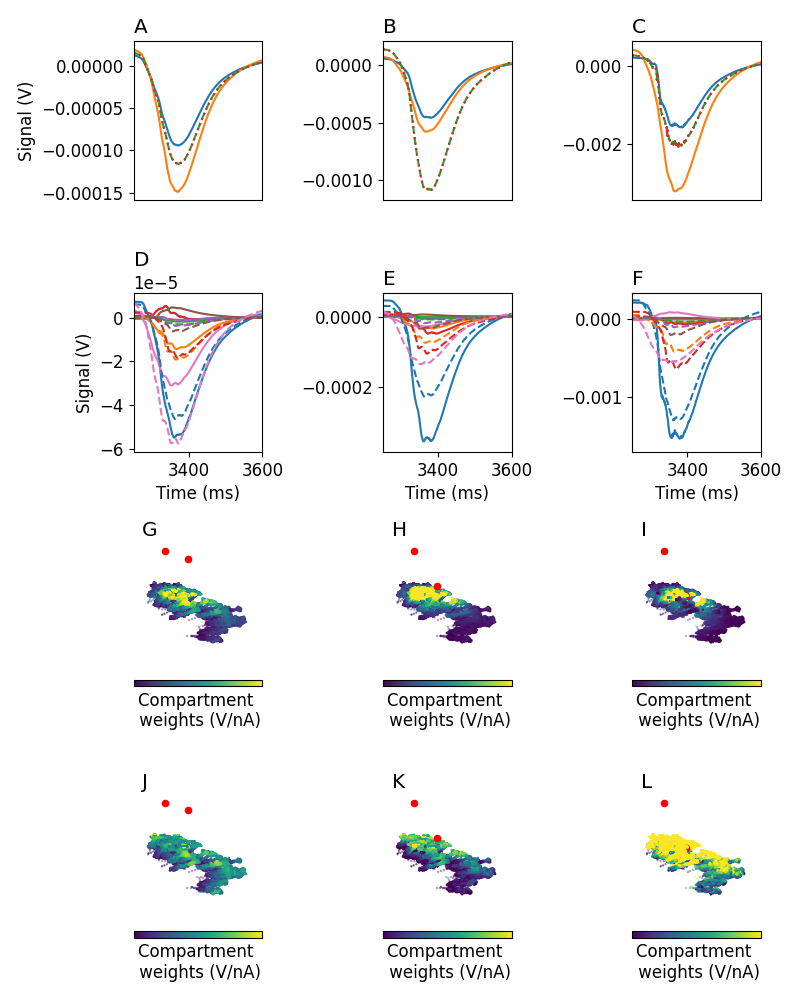

In [38]:
fig = plt.figure(figsize=(8,10))

############
# Plot EEG signals, calculated with each method
ax = plt.subplot(4,3,1)

plt.plot(signalTotal['Forelimb_EEG_Reciprocity']-np.mean(signalTotal['Forelimb_EEG_Reciprocity']))
plt.plot(signalTotal['Forelimb_EEG_Dipole']-np.mean(signalTotal['Forelimb_EEG_Dipole']))
plt.plot(signalTotal['Forelimb_EEG_PointSource']-signalTotal['Reference_PointSource']-np.mean(signalTotal['Forelimb_EEG_PointSource']-signalTotal['Reference_PointSource']),'--')
plt.plot(signalTotal['Forelimb_EEG_LineSource']-signalTotal['Reference_LineSource']-np.mean(signalTotal['Forelimb_EEG_LineSource']-signalTotal['Reference_LineSource']),':')
plt.xticks(visible=False)
plt.xlim([3250,3600])
plt.ylabel('Signal (V)')
plt.xticks([])
ax.set_title('A',ha='left', x=-0)
plt.tight_layout()

ax = plt.subplot(4,3,2)

# Plots ECoG Signals, calculated with each method
plt.plot(signalTotal['Forelimb_ECoG_Reciprocity']-np.mean(signalTotal['Forelimb_ECoG_Reciprocity']))
plt.plot(signalTotal['Forelimb_ECoG_Dipole']-np.mean(signalTotal['Forelimb_ECoG_Dipole']))
plt.plot(signalTotal['Forelimb_ECoG_PointSource']-signalTotal['Reference_PointSource']-np.mean(signalTotal['Forelimb_ECoG_PointSource']-signalTotal['Reference_PointSource']),'--')
plt.plot(signalTotal['Forelimb_ECoG_LineSource']-signalTotal['Reference_LineSource']-np.mean(signalTotal['Forelimb_ECoG_LineSource']-signalTotal['Reference_LineSource']),':')
plt.xticks(visible=False)
plt.xlim([3250,3600])
plt.xticks([])
ax.set_title('B',ha='left', x=-0)
plt.tight_layout()

ax = plt.subplot(4,3,3)

# Plots LFP Signals, claculated with each method
plt.plot(signalTotal['Forelimb_LFP_Reciprocity']-np.mean(signalTotal['Forelimb_LFP_Reciprocity']))
plt.plot(signalTotal['Forelimb_LFP_Dipole']-np.mean(signalTotal['Forelimb_LFP_Dipole']))
plt.plot(signalTotal['Forelimb_LFP_PointSource']-signalTotal['Reference_PointSource']-np.mean(signalTotal['Forelimb_LFP_PointSource']-signalTotal['Reference_PointSource']),'--')
plt.plot(signalTotal['Foreelimb_LFP_LineSource']-signalTotal['Reference_LineSource']-np.mean(signalTotal['Foreelimb_LFP_LineSource']-signalTotal['Reference_LineSource']),':')
plt.xticks([])
plt.xlim([3250,3600])
ax.set_title('C',ha='left', x=-0)
plt.tight_layout()
####################

# Plots contribution of each region to EEG signals, calculated with Reciprocity and Dipole methods
ax = plt.subplot(4,3,4)

for i, region in enumerate(regions):
    plt.plot(byRegion[region]['Forelimb_EEG_Reciprocity']-np.mean(byRegion[region]['Forelimb_EEG_Reciprocity']),c='C'+str(i))

for i, region in enumerate(regions):   
    plt.plot(byRegion[region]['Forelimb_EEG_Dipole']-np.mean(byRegion[region]['Forelimb_EEG_Dipole']),'--',c='C'+str(i))

plt.xlim([3250,3600])
ax.set_title('D',ha='left', x=-0)
plt.ylabel('Signal (V)')
plt.xlabel('Time (ms)')
plt.tight_layout()

###############
# Plots contribution of each region to ECoG signals, calculated with Reciprocity and Dipole methods
ax = plt.subplot(4,3,5)

for i, region in enumerate(regions):
    plt.plot(byRegion[region]['Forelimb_ECoG_Reciprocity']-np.mean(byRegion[region]['Forelimb_ECoG_Reciprocity']),c='C'+str(i))

for i, region in enumerate(regions):   
    plt.plot(byRegion[region]['Forelimb_ECoG_Dipole']-np.mean(byRegion[region]['Forelimb_ECoG_Dipole']),'--',c='C'+str(i))

plt.xlim([3250,3600])
ax.set_title('E',ha='left', x=-0)
plt.xlabel('Time (ms)')
plt.tight_layout()

###############
# Plots contribution of each region to LFP signals, calculated with Reciprocity and Dipole methods
ax = plt.subplot(4,3,6)

for i, region in enumerate(regions):
    plt.plot(byRegion[region]['Forelimb_LFP_Reciprocity']-np.mean(byRegion[region]['Forelimb_LFP_Reciprocity']),c='C'+str(i))

for i, region in enumerate(regions):   
    plt.plot(byRegion[region]['Forelimb_LFP_Dipole']-np.mean(byRegion[region]['Forelimb_LFP_Reciprocity']),'--',c='C'+str(i))


plt.xlim([3250,3600])
ax.set_title('F',ha='left', x=-0)
plt.xlabel('Time (ms)')
plt.tight_layout()
###############################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG, calculated with reciprocity method

ax = fig.add_subplot(4,3,7,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFl
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHl
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('G',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for ECoG, calculated with reciprocity method

ax = fig.add_subplot(4,3,8,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlEcog
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlEcog
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpEcog
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values

    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=15e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(ecog[0],ecog[1],ecog[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('H',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for LFP, calculated with reciprocity method
ax = fig.add_subplot(4,3,9,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlLfp
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlLfp
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpLfp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values

    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-8,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(lfp[0],lfp[1],lfp[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('I',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################

#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG, calculated with dipole method

ax = fig.add_subplot(4,3,10,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlDipole
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlDipole
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpDipole
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('J',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for ECoG, calculated with dipole method

ax = fig.add_subplot(4,3,11,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlDipoleEcog
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlDipoleEcog
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpDipoleEcog
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=15e-9,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(ecog[0],ecog[1],ecog[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('K',ha='left', x=-0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))
#####################
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for LFP, calculated with dipole method
ax = fig.add_subplot(4,3,12,projection='3d')

for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFlDipoleLfp
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHlDipoleLfp
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULpDipoleLfp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-8,s=.5)
    
ax.view_init(elev=9., azim=-85)

ax.scatter(lfp[0],lfp[1],lfp[2],c='r',s=20)
ax.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20)

plt.axis('off')
cb = plt.colorbar(im,label='Compartment \n weights (V/nA)',location='bottom')
cb.set_ticks([])
ax.set_title('L',ha='left', x=0)
plt.tight_layout()
ax.set_xlim((2801.1161576783625, 6260.576980695542))
ax.set_ylim((-2284.337284947517, 1883.8635116069354))
ax.set_zlim((-4332.110601382281, 914.4962633882312))

plt.savefig('figures/compareDipole.png',dpi=300)